# Representing Human faces

Folks,

What better application that looking at this hot topic doing the rounds - facial recognition - by machines?

Many applications exist as do many perils. Won't go into that debate here however.

Aim here is to demo the ease with which on open-source systems, ML algos are powerful enough to detect faces and more.

To improve these ML algos, feature representation and re-engg of the sort we glimpsed today are very helpful in.

Step 1 would be downloading the famous lfw (Labeled Faces in the Wild) dataset of celebrity faces from the early 2000s. 

We use gray-scale versions of these images and scale them down further for faster processing.

Behold.


In [3]:
# setup chunk
# ! pip mglearn
import mglearn
from sklearn.datasets import fetch_lfw_people
import time
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt

# download lfw
t1 = time.time()
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
t2 = time.time()
print(round(t2-t1,2), " secs")  # 54 secs

0.76  secs


size of one image in pixels is:  (87, 65)


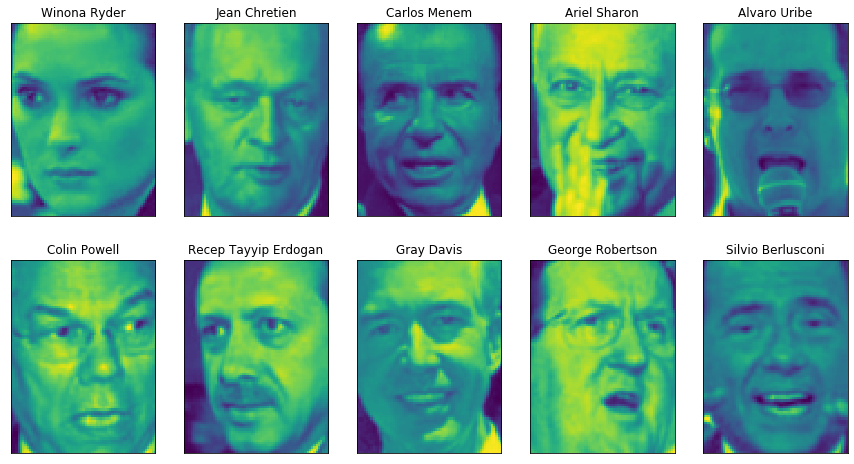

In [4]:
# find img dimns
image_shape = people.images[0].shape
print("size of one image in pixels is: ", image_shape)

# view a few
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
                         subplot_kw={'xticks': (), 'yticks': ()})

for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])


There're 3023 images each of 87x65 pixels size belonging top 62 different people. Here's a count of how many for who:

In [5]:
print("people.images.shape: ", (people.images.shape))
print("Number of classes: ", len(people.target_names))
print("=======\n")

# count how often each target appears
counts = np.bincount(people.target)
# print counts next to target names:
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

people.images.shape:  (3023, 87, 65)
Number of classes:  62

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Je

OK. So what's the ask here? The task here?

Aim is to train a machine to recognize faces and tell us if apreviously unseen face belongs to a known person from a database.
`
Since we're focussed on the basics, let's simplify task a little more. Let's eschew the skew and balance the dataset. 

IOW, we'll only select 50 faces per person and train the machine to recognize a label just from the face's features.

### Rebalance the dataset for training


In [6]:
# create a mask for logical vector storage
mask = np.zeros(people.target.shape, dtype=np.bool)

# filter data based on target obs >=50 
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

# filter in only those who meet above criteria    
X_people = people.data[mask]
y_people = people.target[mask]
# print("Num of janta selected: ", len(y_people))

# scale the grey-scale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability:
X_people = X_people / 255.

Ok. All set. Time now to train a classifier.

Let's start simple. With kNN. With k=1. Just to see how it does.

Then we'll add other options to improve things.

### Trying kNN with k=1

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# split the data in training and test set
X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)

# build a KNeighborsClassifier with using one neighbor:
t1 = time.time()
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
t2 = time.time()

print("kNN withk=1 took: ", round(t2-t1, 2), " secs")
print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))


kNN withk=1 took:  3.42  secs
Test set score of 1-nn: 0.23


A measly 23% accuracy? Bah. However remember this ain't a binary classification problem but a 62-class problem. 

So by random chance we only have a 1/62 ~ 1.5% chance of getting something right. So 23% ain't bad but ain't great either.

Maybe changing k in KNN will help? Turns out at k=2, things worsen. Sigh.

Let's now ask - how exactly is kNN classifying these images? 

kNN takes each pixel in the 87x65=5655 pixles out there, then computes its Euclidean distance from the corresponding pixel in the training set, then sums up all such distances to get a measure of inter-face 'distance'.

Humans clearly dont take this approach to face recognition. Maybe there's a better representation out there that can both help classifiers train better as well as humans intuit better? maybe PCA can help here? 

There's at least one way to find out. Let's go there.

### Using PCA to re-engineer features & data representation


In [9]:
from sklearn.decomposition import PCA

# instantiate and fit PCA model for say, 100 compts
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca.shape: {}".format(X_train_pca.shape))

X_train_pca.shape: (1547, 100)


New set of features are 100 in number and are the top 100 variance explaining projections. 

Let's see if the kNN classifier applied again on these reengineered features do any better, eh?

In [10]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)

print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))
print("pca.components_.shape: {}".format(pca.components_.shape))

Test set accuracy: 0.31
pca.components_.shape: (100, 5655)


31%. Quite an improvement over 23% previously. 

So it does seem as if PCs did provide a better representation of the data for ML.

But what are these PCs anyway? Let's see whatthe first few PCs show and see if they have any intuitive explanation.

Behold

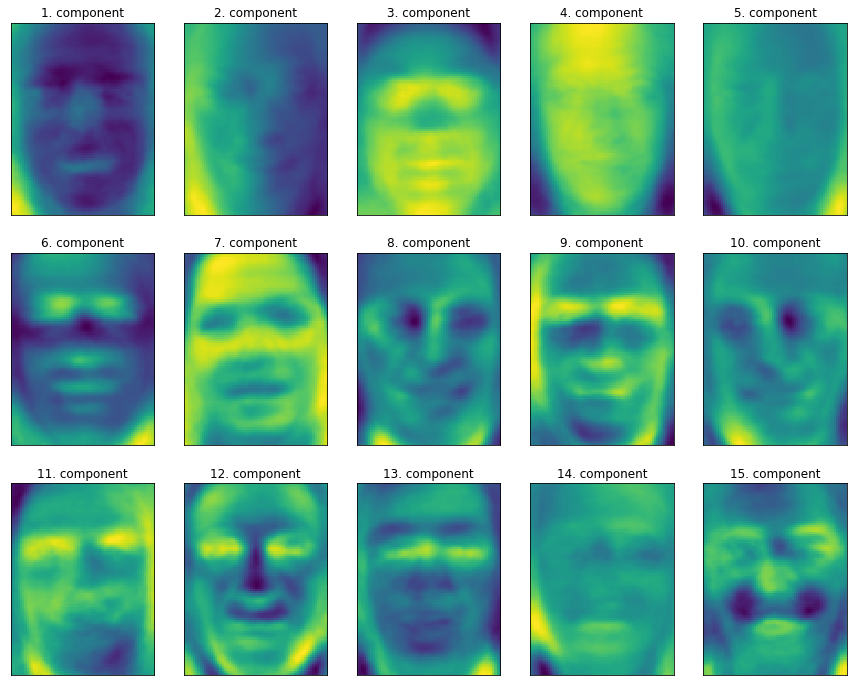

In [11]:
# plot the first few PCS
fig, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})

# for-loop across PCs and show
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape),
              cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))

A little better but only a little. For instance, look carefully and see:

- PC1 seems to encode contrast between face and background.
- PC2 seems to encode differences in lighting between left and right sides of the face. And so on.
- Not every PC is interpretable in raw intuitive terms.
- Clearly, differences in angle and lighting can drastically change inter-image distances etc. and ML classifications but wouldn't fool humans much.

Recall what PCA does. It retains compts in terms of max variance explained. So cumulatively adding PCs should render ever better resolutions of the data.

See below a demo sample on lfw data from mglearn edu module.

C:\Users\20052\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\20052\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


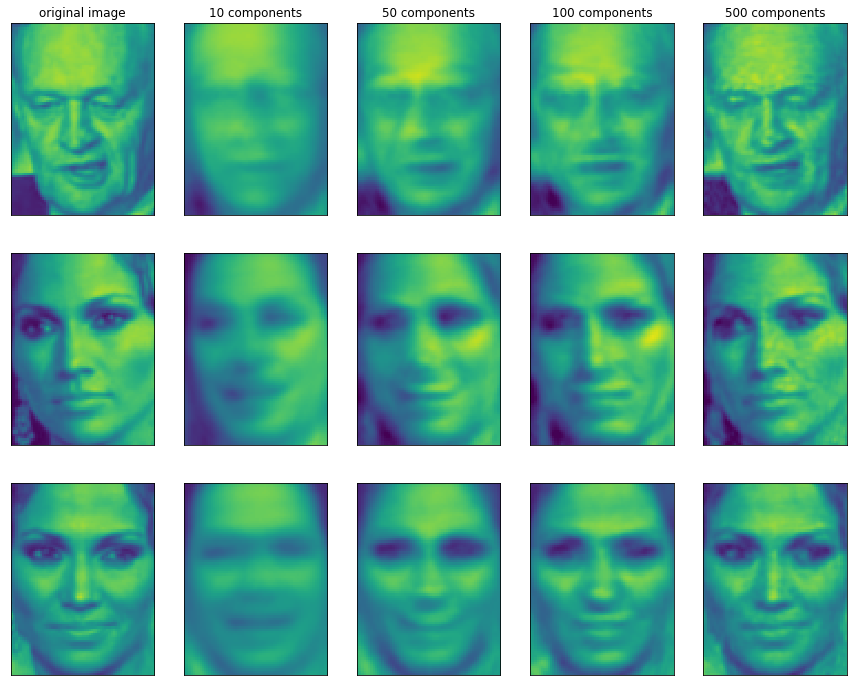

In [13]:
import mglearn
mglearn.plots.plot_pca_faces(X_train, X_test, image_shape)

## k-means analysis of the faces dataset

Recall what k-means allowed us to do last time on an image? 

This time, plan is to run k=10 clusters and for each, we can see the cluster center wala face. 

IOW, we can see the *average* face of all faces in a cluster of faces sharing similar feature values. 

The *prototypical* or perhaps *archewtypical* face, eh?

Behold.

Cluster sizes k-means:  [230 324  81 280 237 210  73 104 211 313]


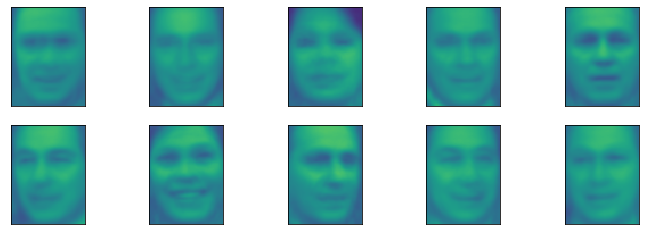

In [15]:
from sklearn.cluster import KMeans  
# extract clusters with k-Means
km = KMeans(n_clusters=10, random_state=0)
X_pca = pca.transform(X_people)
labels_km = km.fit_predict(X_pca)
print("Cluster sizes k-means: ", np.bincount(labels_km))

# plot the cluster center faces
fig, axes = plt.subplots(2, 5, subplot_kw={'xticks': (), 'yticks': ()},
                         figsize=(12, 4))

for center, ax in zip(km.cluster_centers_, axes.ravel()):
    ax.imshow(pca.inverse_transform(center).reshape(image_shape),
              vmin=0, vmax=1)

Unsurprisingly, the above show very smooth faces due to 2 reasons. 

- One, each face there is the average of 64-386 faces. 

- Two, the PCs are a smoothed down version of the original data anyway.

- Further, note the clustering seems to pick up different orientations of the face, different expressions (e.g., 3rd face seems to be smiling) as well as shirt-collar presence (see second to last one). 

Here below, I wrote code to juxtapose the cluster center face plot with some faces from the same cluster. 

Behold.

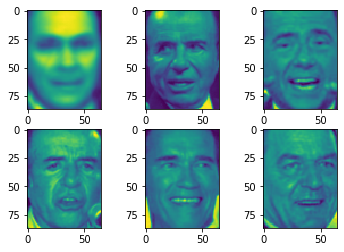

In [16]:
clus_num = 3  # specify which cluster to see
a0 = km.cluster_centers_; a0.shape
a1 = km.labels_; a1.shape
a2 = pca.inverse_transform(km.cluster_centers_[clus_num, :]).reshape(image_shape)
# plt.imshow(a2)

a3_logi = (a1==clus_num)
a3_imgs = X_people[a3_logi,:][:5]
img1 = []
for img in a3_imgs:
	img0 = img.reshape(image_shape)
	img1.append(img0)
	# plt.imshow(img0)

fig, b = plt.subplots(2, 3)
b[0][0].imshow(a2)
b[0][1].imshow(img1[0])
b[0][2].imshow(img1[1])
b[1][0].imshow(img1[2])
b[1][1].imshow(img1[3])
b[1][2].imshow(img1[4])
plt.show()

Well, dassit for now. Back to the slides.

Voleti